# Corporate event trading

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#hide
from IPython.display import display, Image

## Earnings announcement premium

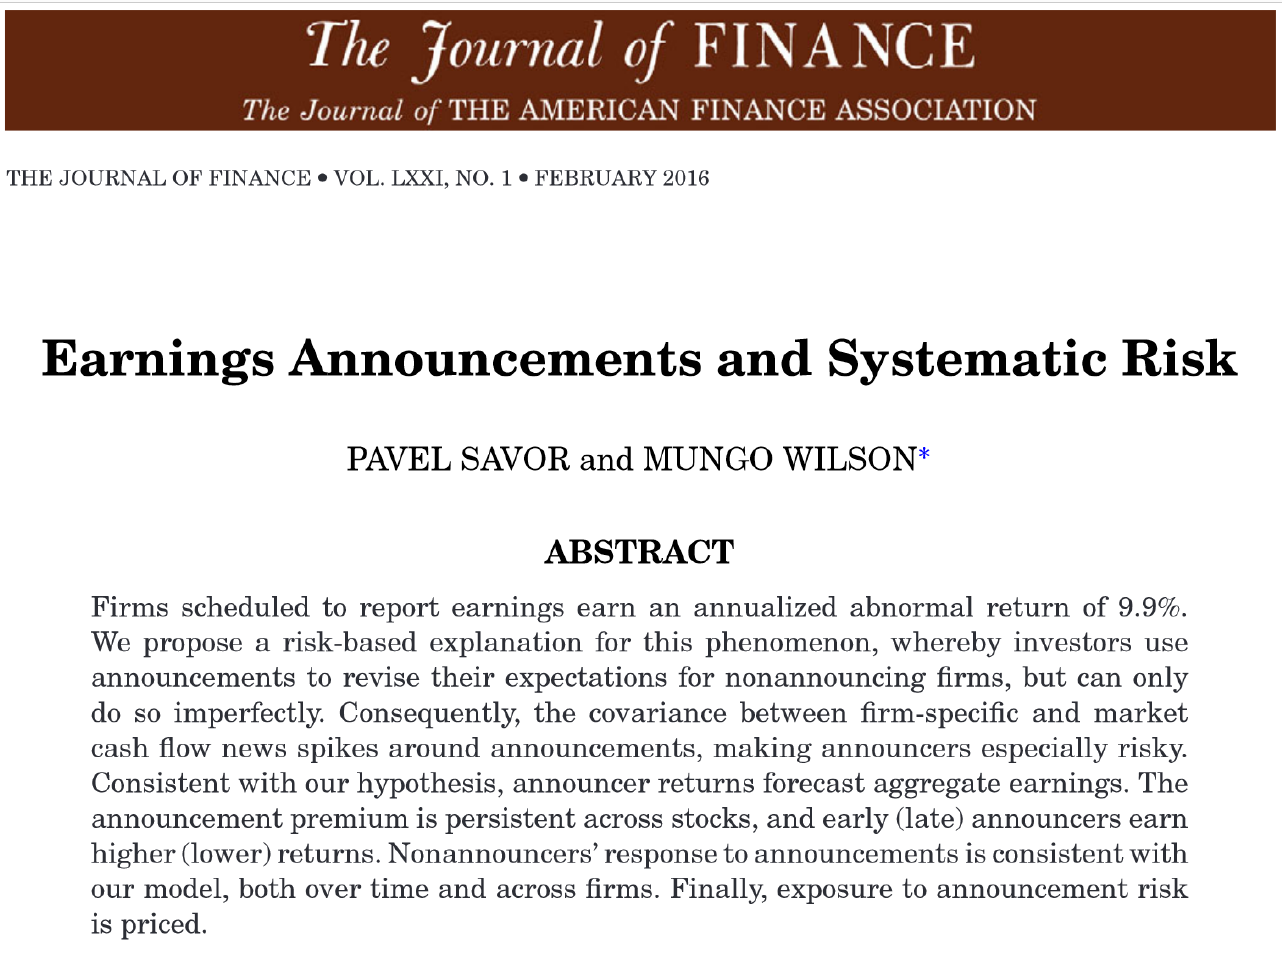

In [3]:
#hide 
display(Image('images/savor_ea_1.png',width=500))

Main statements in Savor and Wilson (2016):

1. earnings announcement premium = 9.9% / year 
1. announcing firms are "risky" and therefore there should be a compensation for risk
1. more precisely, firm earnings contain news about market cash-flow risk and therefore matter for aggreate risk

We focus on the first point. 

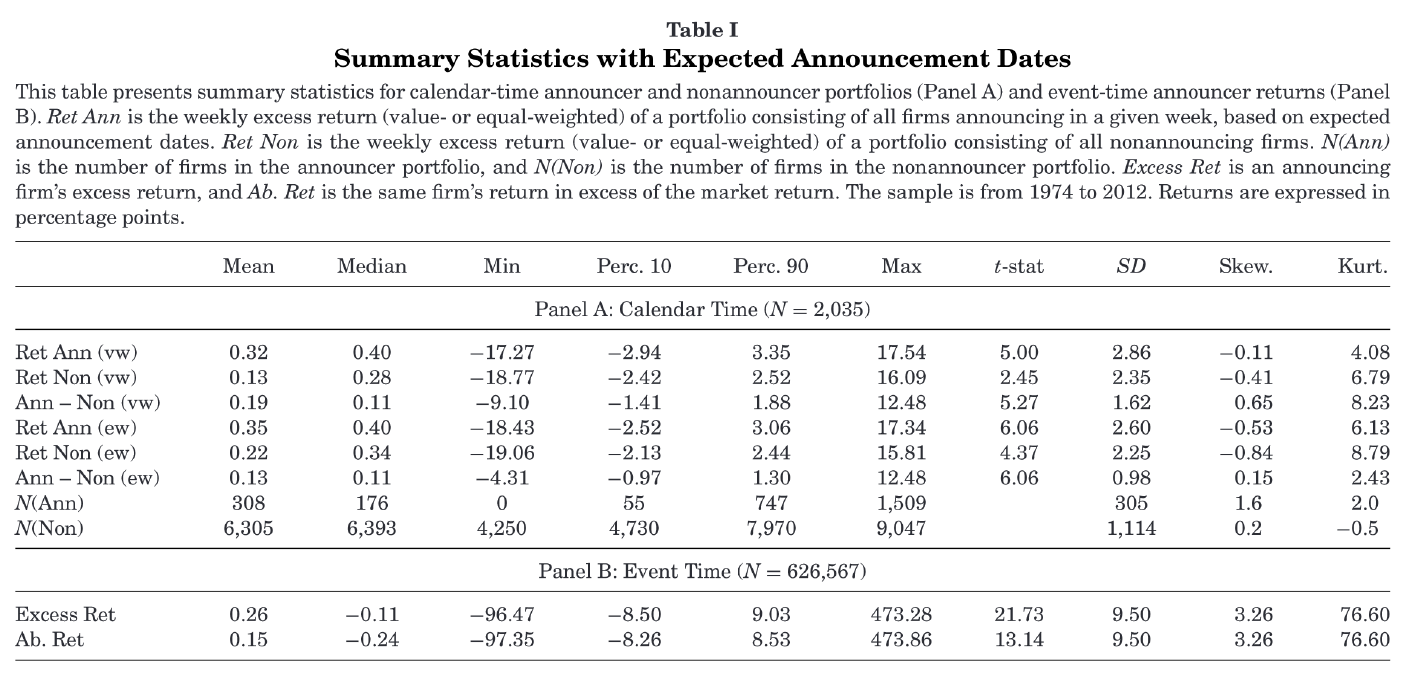

In [4]:
#hide 
display(Image('images/savor_ea_2.png',width=700))

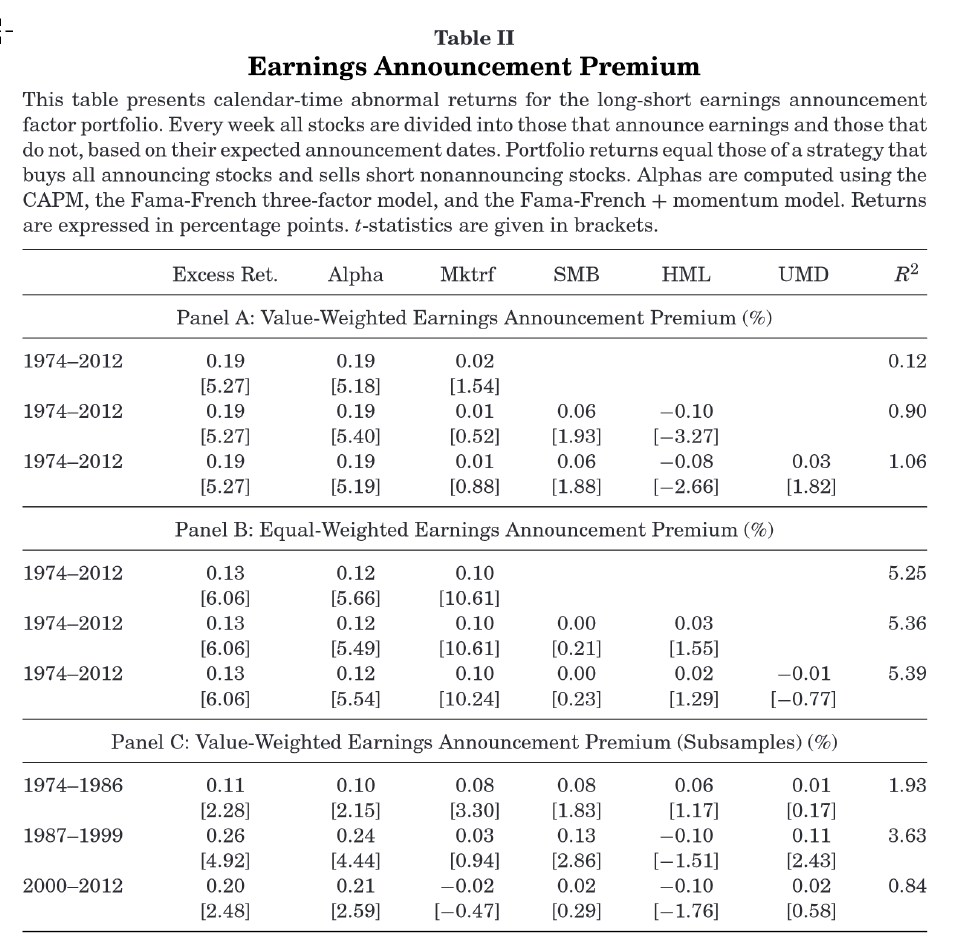

In [5]:
#hide 
display(Image('images/savor_ea_3.png',width=500))

## Regulatory filings

The main regulatory filings to the U.S. Securities and Exchange Commission (SEC) are known as the 10-Ks and 10-Qs. 

- The 10-K is an annual report  required by the U.S. Securities and Exchange Commission (SEC) that gives a summary of the company's financial performance (and includes information such as company history, executive compensation, etc). 
- The 10-Q is a quarterly report and contains similar information as the 10-K, but with less details. 

The regulatory filings and the earning conference calls take place typically on the same day, so that all the market-moving information is disclosed to the market at the same time. 

## Filing dates from 10-Ks/10-Qs

In this section, we use the sample of firms from the daily stock return dataset and match it to the McDonald repository (https://sraf.nd.edu/) used in particular in the Loughran-McDonald paper. 

In [6]:
from skfin.plot import line, bar
from skfin.datasets import load_sklearn_stock_returns, load_10X_summaries, mapping_10X
ret = load_sklearn_stock_returns(cache_dir="data")

INFO:skfin.datasets:logging from cache directory: data/sklearn_returns.parquet


In [7]:
df = load_10X_summaries()

INFO:skfin.datasets:logging from cache directory: /home/schamponn/dev/projects/skfin/nbs/data/Loughran-McDonald_10X_Summaries_1993-2021.csv


In [8]:
df.sample(n=5).iloc[:, :10]

,CIK,FILING_DATE,ACC_NUM,CPR,FORM_TYPE,CoName,SIC,FFInd,N_Words,N_Unique_Words
185938,1060530,19981214,0001047469-98-043803,19980930,10-Q-A,FALCON COMMUNICATIONS LP,4841,32,2573,551
979885,1144519,20160428,0001104659-16-115315,20160331,10-Q,Bunge LTD,2070,2,19782,1851
755889,850693,20100226,0001193125-10-043126,20091231,10-K,ALLERGAN INC,2834,13,105872,4286
273919,1100730,20000705,0001074413-00-000003,19991231,10KSB,MILLENNIUM SOFTWARE INC,7389,34,13788,1739
95606,920448,19970513,0000950005-97-000512,19970331,10-Q,BROADVISION INC,7372,34,6249,1145


The mapping of stock tickers to company name is `mapping_10X`:
- given that the name of firms can change (e.g. "Dell computer corp" becoming "Dell inc"), all the possible names need to be tracked. 

In [9]:
random.choices(list(mapping_10X.items()), k=10)

[('KMB', 'KIMBERLY CLARK CORP'),
 ('YHOO', 'YAHOO INC'),
 ('MCD', 'MCDONALDS CORP'),
 ('AAPL', ['APPLE COMPUTER INC', 'APPLE INC']),
 ('VLO', 'VALERO ENERGY CORP/TX'),
 ('PEP', 'PEPSI BOTTLING GROUP INC'),
 ('CAT', 'CATERPILLAR INC'),
 ('MMM', '3M CO'),
 ('CL', 'COLGATE PALMOLIVE CO'),
 ('CL', 'COLGATE PALMOLIVE CO')]

The table below shows the number of regulatory filings over time for the selected firms. 

In [10]:
pd.DataFrame.from_dict({k: df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])]\
                            .set_index('date')\
                            .loc[ret.index[0]:ret.index[-1]]\
                            .groupby(['FORM_TYPE'])['FILING_DATE'].count()
                        for k, v in mapping_10X.items()}, orient='index')\
            .assign(**{'10_K_Q': lambda x:x['10-K'] + x['10-Q'], 
                      'restatements': lambda x:x['10-K-A'] + x['10-Q-A'] })\
            .sort_values(['10_K_Q', 'restatements']).fillna(0).astype(int)

,10-K,10-Q,10-K-A,10-Q-A,10_K_Q,restatements
NAV,3,9,0,0,12,0
CVC,6,12,6,2,18,8
BA,5,15,1,1,20,2
PEP,5,15,1,1,20,2
F,5,15,1,3,20,4
GE,5,15,2,3,20,5
WFC,5,15,2,3,20,5
JPM,5,15,5,1,20,6
TWX,5,15,2,4,20,6
AIG,5,15,2,5,20,7


### mapping checks

In [11]:
v = mapping_10X['CVC']
print(v)
df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])].set_index('date')\
  .loc[ret.index[0]:ret.index[-1]].loc['2006'].iloc[:, :10]

CABLEVISION SYSTEMS CORP /NY


,CIK,FILING_DATE,ACC_NUM,CPR,FORM_TYPE,CoName,SIC,FFInd,N_Words,N_Unique_Words
date,,,,,,,,,,
2006-05-10,1053112,20060510,0001104659-06-032803,20060331,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,38566,2327
2006-05-10,784681,20060510,0001104659-06-032803,20060331,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,38566,2327
2006-09-21,1053112,20060921,0001104659-06-062197,20051231,10-K-A,CABLEVISION SYSTEMS CORP /NY,4841,32,92495,2946
2006-09-21,784681,20060921,0001104659-06-062197,20051231,10-K-A,CABLEVISION SYSTEMS CORP /NY,4841,32,92495,2946
2006-09-21,1053112,20060921,0001104659-06-062201,20060331,10-Q-A,CABLEVISION SYSTEMS CORP /NY,4841,32,35794,1966
2006-09-21,784681,20060921,0001104659-06-062201,20060331,10-Q-A,CABLEVISION SYSTEMS CORP /NY,4841,32,35794,1966
2006-11-08,1053112,20061108,0001104659-06-072875,20060930,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,45265,2148
2006-11-08,784681,20061108,0001104659-06-072875,20060930,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,45265,2148


Matching company names is often a time-consuming task: below we use the package `rapidfuzz` to check the candidate matches. 

In [12]:
CoName = list(df.assign(CoName = lambda x:x.CoName.str.upper())\
              .groupby(['date', 'CoName'])['FILING_DATE'].count()\
             .loc[ret.index[0]:ret.index[-1]]\
             .groupby(level=1).count().index)

from rapidfuzz import fuzz
pd.Series({c: fuzz.token_set_ratio('CABLEVISION', c) for c in CoName}).sort_values(ascending=False).head(5)

CABLEVISION SYSTEMS CORP /NY    100.000000
PARKERVISION INC                 66.666667
CAGLES INC                       66.666667
ABLEST INC                       66.666667
LATIN TELEVISION  INC            64.516129
dtype: float64

## Stock returns on filing dates

In [13]:
ret_norm = ret.pipe(lambda x: x.div(x.ewm(halflife=63, min_periods=21).std()))\
              .dropna(how='all',axis=0)

mask = pd.concat({k: df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])]\
                            .set_index('date')\
                            .loc['2002-01-01':ret.index[-1]]['FORM_TYPE']
           for k, v in mapping_10X.items()}).groupby(level=[1, 0]).count()

funcs = {'ea': lambda x: x.loc[x.FORM_TYPE.notna()].drop('FORM_TYPE', axis=1), 
         'not_ea': lambda x: x.loc[x.FORM_TYPE.isna()].drop('FORM_TYPE', axis=1)}

ret_ea = pd.concat({k: ret_norm.stack().rename('ret').to_frame().join(mask).pipe(v).squeeze() 
                    for k, v in funcs.items()}, axis=1)

The histogram below shows more extreme returns on filing dates.

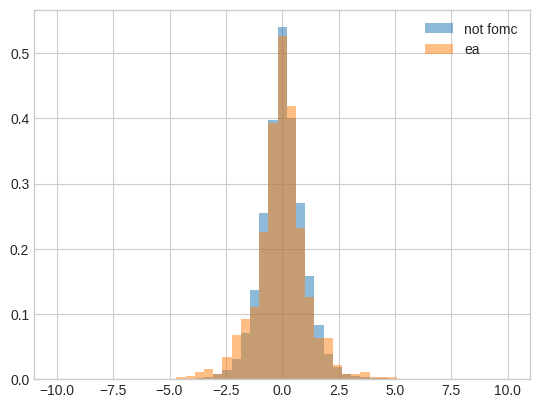

In [14]:
bins = np.linspace(-10, 10, 50)
plt.hist(ret_ea['not_ea'].dropna(), bins, density=True, alpha=0.5, label='not fomc')
plt.hist(ret_ea['ea'].dropna(), bins, density=True, alpha=0.5, label='ea')
plt.legend(loc='upper right')
plt.show()

Statistically, this is confirmed with a higher volatility on filing dates. On this sample, the average returns do not seem different.

In [15]:
pd.concat({'Average volatility': ret_ea.std(), 'Average mean': ret_ea.mean()}, axis=1).round(2)

,Average volatility,Average mean
ea,1.11,-0.04
not_ea,0.97,0.04


In [16]:
ea_std, ea_mean = {}, {}
for i in range(-5, 5): 
    mask_ = mask.unstack().reindex(ret.index).shift(i).stack().rename('FORM_TYPE')
    ret_ea_ = pd.concat({k: ret_norm.stack().rename('ret').to_frame().join(mask_).pipe(v).squeeze() 
                        for k, v in funcs.items()}, axis=1)
    ea_std[i] = ret_ea_.std()
    ea_mean[i] = ret_ea_.mean()

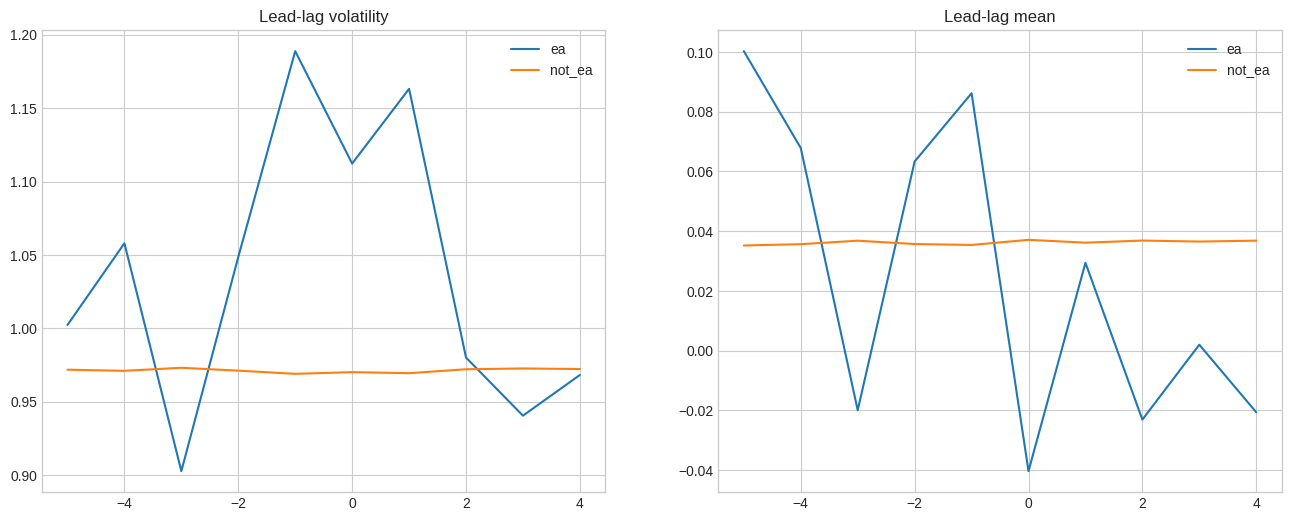

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
line(pd.DataFrame(ea_std).T, title='Lead-lag volatility', sort=False, ax=ax[0], bbox_to_anchor=None, loc='best')
line(pd.DataFrame(ea_mean).T, title='Lead-lag mean', sort=False, ax=ax[1], bbox_to_anchor=None, loc='best')